# 轻量化数据处理

`Ascend` `GPU` `CPU` `数据准备`

[![在线运行](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_modelarts.png)](https://authoring-modelarts-cnnorth4.huaweicloud.com/console/lab?share-url-b64=aHR0cHM6Ly9taW5kc3BvcmUtd2Vic2l0ZS5vYnMuY24tbm9ydGgtNC5teWh1YXdlaWNsb3VkLmNvbS9ub3RlYm9vay9tb2RlbGFydHMvcHJvZ3JhbW1pbmdfZ3VpZGUvbWluZHNwb3JlX2VhZ2VyLmlweW5i&imageid=65f636a0-56cf-49df-b941-7d2a07ba8c8c)&emsp;[![下载Notebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/programming_guide/zh_cn/mindspore_eager.ipynb)&emsp;[![下载样例代码](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/programming_guide/zh_cn/mindspore_eager.py)&emsp;[![查看源文件](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/experts/source_zh_cn/data_engine/eager.ipynb)

## 概述

在资源条件允许的情况下，为了追求更高的性能，一般使用数据管道模式执行数据增强算子。基于数据管道模式执行的最大特点是需要定义`map`算子，如下图中将`Resize`、`Crop`、`HWC2CHW`算子交由`map`算子调度，由其负责启动和执行给定的数据增强算子，对数据管道的数据进行映射变换。

![pipelinemode1](./images/pipeline_mode.jpeg)

虽然构建数据管道可以批量处理输入数据，但是数据管道的API设计要求用户从构建输入源开始，逐步定义数据管道中的各个处理算子，仅当在定义`map`的时候才会涉及与用户输入数据高度相关的数据增强算子。无疑，用户只想重点关注这些与其相关度最高的代码，但其他相关度较低的代码却在整个代码场景中为用户增加了不必要的负担。

因此，MindSpore提供了一种轻量化的数据处理执行方式，称为Eager模式。

在Eager模式下，执行数据增强算子不需要依赖构建数据管道`map`，而是以函数式调用的方式执行数据增强算子。因此代码编写会更为简洁且能立即执行得到运行结果，推荐在小型数据增强实验、模型推理等轻量化场景中使用。

![eagermode1](./images/eager_mode.jpeg)

MindSpore目前支持在Eager模式执行各种数据增强算子，具体如下所示，更多数据增强算子参见API文档。

- [vision模块](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.vision.html)

    - 子模块c_transforms，基于OpenCV实现的图像增强算子。
    - 子模块py_transforms，基于Pillow实现的图像增强算子。

- [text模块](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.text.html#mindspore-dataset-text-transforms)

    - 子模块transforms，文本处理算子。

- [transforms模块](https://www.mindspore.cn/docs/zh-CN/master/api_python/mindspore.dataset.transforms.html)

    - 子模块c_transforms，基于C++实现的通用数据增强算子。
    - 子模块py_transforms，基于Python实现的通用数据增强算子。

注：在章节[图像处理与增强](https://www.mindspore.cn/docs/programming_guide/zh-CN/master/augmentation.html)、[文本处理与增强](https://www.mindspore.cn/docs/programming_guide/zh-CN/master/tokenizer.html)中介绍的数据增强算子，均可以以Eager模式执行。

## 示例

下面将简要介绍数据增强各模块算子的Eager模式使用方法。

> 使用Eager模式，只需要将数据增强算子本身当成可执行函数即可。

### 数据准备

以下示例代码将图片数据下载到指定位置。

In [ ]:
import os
import requests

requests.packages.urllib3.disable_warnings()

def download_dataset(dataset_url, path):
    filename = dataset_url.split("/")[-1]
    save_path = os.path.join(path, filename)
    if os.path.exists(save_path):
        return
    if not os.path.exists(path):
        os.makedirs(path)
    res = requests.get(dataset_url, stream=True, verify=False)
    with open(save_path, "wb") as f:
        for chunk in res.iter_content(chunk_size=512):
            if chunk:
                f.write(chunk)
    print("The {} file is downloaded and saved in the path {} after processing".format(os.path.basename(dataset_url), path))

download_dataset("https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/datasets/banana.jpg", ".")

### vision

此示例将混用`vision`模块中的`c_tranforms`与`py_transforms`的算子，对给定图像进行变换。

您仅需要关注使用何种数据增强算子，而不需要关注数据管道的任何代码。

vision算子的Eager模式支持`numpy.array`或`PIL.Image`类型的数据作为入参。

Image.type: <class 'PIL.Image.Image'>, Image.shape: (356, 200)
Image.type: <class 'numpy.ndarray'>, Image.shape: (320, 570, 3)
Image.type: <class 'numpy.ndarray'>, Image.shape: (280, 280, 3)
Image.type: <class 'PIL.Image.Image'>, Image.shape: (360, 360)


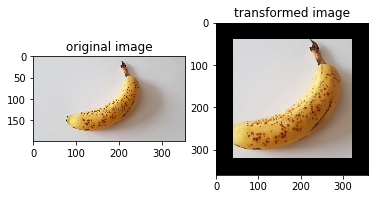

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import mindspore.dataset.vision.c_transforms as C
import mindspore.dataset.vision.py_transforms as P

img_ori = Image.open("banana.jpg").convert("RGB")
print("Image.type: {}, Image.shape: {}".format(type(img_ori), img_ori.size))

# Define a Resize op from c_transform and execute it immediately
op1 = C.Resize(size=(320))
img = op1(img_ori)
print("Image.type: {}, Image.shape: {}".format(type(img), img.shape))

# Define a CenterCrop op from c_transform and execute it immediately
op2 = C.CenterCrop((280, 280))
img = op2(img)
print("Image.type: {}, Image.shape: {}".format(type(img), img.shape))

# Define a Pad op from py_transform and execute it immediately
# Before calling Pad, you need to call ToPIL()
op3 = P.ToPIL()
op4 = P.Pad(40)
img = op4(op3(img))
print("Image.type: {}, Image.shape: {}".format(type(img), img.size))

# Show the result
plt.subplot(1, 2, 1)
plt.imshow(img_ori)
plt.title("original image")
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title("transformed image")
plt.show()

### text

此示例将使用`text`模块中`tranforms`的算子，对给定文本进行变换。

text算子的Eager模式支持`numpy.array`类型数据的作为入参。

In [2]:
import mindspore.dataset.text.transforms as text
from mindspore import dtype as mstype

# Define a WhitespaceTokenizer op and execute it immediately
txt = "Welcome to Beijing !"
txt = text.WhitespaceTokenizer()(txt)
print("Tokenize result: {}".format(txt))

# Define a ToNumber op and execute it immediately
txt = ["123456"]
to_number = text.ToNumber(mstype.int32)
txt = to_number(txt)
print("ToNumber result: {}, type: {}".format(txt, type(txt[0])))


Tokenize result: ['Welcome' 'to' 'Beijing' '!']
ToNumber result: [123456], type: <class 'numpy.int32'>


### transforms

此示例将使用`transforms`模块中`c_tranforms`的的算子，对给定数据进行变换。

transforms算子的Eager模式支持`numpy.array`类型的数据作为入参。

In [3]:
import numpy as np
import mindspore.dataset.transforms.c_transforms as trans

# Define a Fill op and execute it immediately
data = np.array([1, 2, 3, 4, 5])
fill = trans.Fill(0)
data = fill(data)
print("Fill result: ", data)

# Define a OneHot op and execute it immediately
label = np.array(2)
onehot = trans.OneHot(num_classes=5)
label = onehot(label)
print("OneHot result: ", label)

Fill result:  [0 0 0 0 0]
OneHot result:  [0 0 1 0 0]
